In [2]:
from pathlib import Path
import json

In [3]:
data_dir = Path("./data")
if not data_dir.exists():
    data_dir = Path("./")

### Metadata

In [4]:
metadatapath = Path(data_dir).glob('*_metadata.json')
metadata = []
for file in metadatapath:
    data = json.load(file.open(encoding="UTF-8"))
    for dic in data:
        metadata.append(dic)

### Asr data

In [5]:
import re
asr_data = {}
asrdatapath = Path(data_dir).glob('*.gasr.json')
for file in asrdatapath:
    r = re.compile("(?<=-)[^.]+")
    i = r.findall(Path(file).name)
    videoid = i[0]
    asr_data[videoid]=json.load(file.open(encoding="UTF-8"))

### Ans data

In [14]:
anspath = Path(data_dir).glob('*.utterance.ans.txt')
ansdata = {}
for file in anspath:
    r = re.compile("(?<=-)[^.]+")
    i = r.findall(Path(file).name)
    videoid = i[0]
    ansdata[videoid] = file.read_text().split(",")

## 轉注音

In [8]:
#!pip install pypinyin
#!pip install functools
import re
from pypinyin import lazy_pinyin, Style
from difflib import SequenceMatcher
from functools import cache

In [9]:
tone_re = re.compile("[ˊˇˋ˙]")

@cache
def pinyin_cache(ch):
    return lazy_pinyin(ch, style=Style.BOPOMOFO)[0]

class CharPhone:
    def __init__(self, ch):
        assert len(ch)==1
        self.ch = ch
        self.zhuyin = pinyin_cache(ch)
        self.phones = tone_re.sub("", self.zhuyin)
    
    def __hash__(self):
        return hash(self.phones)
    
    def __eq__(self, other):        
        return self.phones == other.phones
    
    def __repr__(self):
        return f"<Char: {self.ch} ({self.zhuyin})>"        

def char_mapper(text):
    text = re.sub("[ \u3000，。：）（]", "", text)
    return [CharPhone(x) for x in text]

## Preprocess ASR

In [10]:
from itertools import chain

def to_num(x):
    return float(x.replace("s", ""))

def flatten_asr(asr_obj):    
    asr_starts = []
    asr_ends = []
    asr_words = []
    for entry_x in asr_obj:
        alts = entry_x.get("alternatives", [])
        if not alts: continue
        words = alts[0].get("words", [])        
        asr_starts.extend([
            to_num(x["startTime"]) for x in words])
        asr_ends.extend([
            to_num(x["endTime"]) for x in words])
        asr_words.extend([x["word"] for x in words])
        
    return {
        "starts": asr_starts,
        "ends": asr_ends,
        "words": asr_words
    }

## Preprocess 議事錄

In [11]:
import re
from itertools import tee
def preprocess_transcript(txt):
    txt = txt.replace("<br />", "")
    txt = re.sub("(\n\d+\n.+)", "", txt)
    txt = re.sub("（.+時.+分）", "", txt)
    txt = re.split("(\n?.+?：)(?=[^「])", txt)    
    txt = [x.replace("\n", "").strip() for x in txt]
    txt = [x for x in txt if x]
    txt = [re.split("，|。|？|！|；", x) for x in txt]

    y = []
    for x in txt:
        if re.search("(\n?.+?：)",x[0]):
            y.append(x[0])
        else:
            x_utter = [i for i in x if i]
            y.append(x_utter)

    iter_list = [iter(y)] * 2
    utterance = [(a,b) for a,b in zip(*iter_list)]
    try: utterance = [x for x in utterance if not re.search("主席：", x[0])]
    except: pass
    #utter = [x for x in utter if not x[0].startswith("主席：")]
    return utterance

In [67]:
#127873
txt = [x for x in metadata if x["video_id"]=="127873"][0]["transcript"]

txt = txt.replace("<br />", "")
txt = re.sub("(\n\d+\n.+)", "", txt)
txt = re.sub("（.+時.+分）", "", txt)
txt = re.split("(\n?.+?：)(?=[^「])", txt)
txt = [x.replace("\n", "").strip() for x in txt]
txt = [x for x in txt if x]
txt = [re.split("，|。|？|！|；", x) for x in txt]

y = []
for x in txt:
    if re.search("(\n?.+?：)", x[0]):
        y.append(x[0])
    else:
        x_utter = [i for i in x if i]
        y.append(x_utter)

iter_list = [iter(y)] * 2
utterance = [(a,b) for a,b in zip(*iter_list)]
try: 
    utterance = [x for x in utterance if not re.search("主席：", x[0])]
except: pass

In [60]:
utterance

[('魯委員明哲：',
  ['楊主委早',
   '世界客家博覽會剛才很多委員也問過',
   '對我來說',
   '在桃園辦是一件好事',
   '但現在覺得好亂',
   '一件好事為什麼弄得那麼亂']),
 ('主席（林委員思銘）：', ['請客委會楊主任委員說明']),
 ('楊主任委員長鎮：', ['不會啦', '我們會把它整理、梳理']),
 ('魯委員明哲：',
  ['我待會會把亂點跟你慢慢說',
   '我希望中央的客委會你們也要多用點心',
   '世博會我們補助 12 億',
   '占 15 億的 80%',
   '我們當然相信桃園市政府有這個能力',
   '因為過去也辦過一些大型活動',
   '如果你不要打「世界」',
   '就跟你沒有關係',
   '你打「世界客家博覽會」',
   '跟你的關係是非常大',
   '你想想看',
   '如果日本東奧辦不成、辦了很久',
   '是東京丟人、還是日本丟人多一點',
   '你自己去想這個問題……']),
 ('楊主任委員長鎮：', ['對', '當然是……']),
 ('魯委員明哲：',
  ['你不要打「世界博覽會」都沒問題喔',
   '所以我希望你跟桃園市政府',
   '就這件事情要多溝通',
   '那這個時間到底誰決定的',
   '那天我跟你聊了',
   '原本是說明年 7 月 15 日到 9 月 15 日',
   '最後的決定到底是什麼',
   '你們討論的過程',
   '原本是更晚一點',
   '後來又往前調整',
   '現在又整個往後延一年',
   '因為他們在市議會都說',
   '是中央決定的',
   '那中央決定的',
   '我就要注意一下',
   '是不是主委你決定的',
   '這是第一個問題']),
 ('楊主任委員長鎮：',
  ['就第一個問題',
   '剛剛提到的',
   '那之所以會往前',
   '就是因為那時候外界有質疑說',
   '跟選舉那麼靠近',
   '會不會被誤會跟選舉有關',
   '在臺灣我們常常都在選舉',
   '所以辦重大活動常常被附會到政治這個想像空間裡面',
   '這當然不是一個好的常態',
   '所以那時候我們認為說 OK 是不是可以再往前調',
   '所以就有這樣的聲音',

## Ans metric

In [16]:
def compute_metric(aligned, ans, tol=3.):
    assert len(aligned) == len(ans)
    n_correct = 0

    for aligned_x, ans_x in zip(aligned, ans):
        t = datetime.strptime(ans_x,"%H:%M:%S")
        ansTD = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds()
        alignTD = timedelta(seconds=aligned_x).total_seconds()

        error = abs(ansTD-alignTD)

        if error < tol:
            n_correct += 1
    metric = n_correct/len(aligned)
    return metric

## 注音對齊

In [17]:
from difflib import SequenceMatcher
from tqdm.auto import tqdm
import numpy as np
from datetime import datetime, timedelta
import json
from scipy.stats import poisson

In [70]:
def zhuyin_matching(key, weight_add=15, weight_mul=2.0, win=10, offset=0, mode="add", id_skip=False):
    asr = asr_data[key]["response"]["results"]
    transcript = [x for x in metadata if x["video_id"]==key][0]["transcript"]
    mdspeaker = [x for x in metadata if x["video_id"]==key][0]["speaker"]
    
    flat_asr = flatten_asr(asr)
    assert len(flat_asr["starts"]) == len(flat_asr["words"])

    turns = preprocess_transcript(transcript)
    
    asr_words = flat_asr["words"] 
    asr_starts = flat_asr["starts"]
    asr_ends = flat_asr["ends"]

    aligned_utterance_start = []
    current_idx = 0
    for turn_x in turns:
        for utterance_x in turn_x[1]:
            probe = utterance_x[offset:offset+win]    

            scores = []
            for i in range(len(asr_words)-win):                
                target = "".join(asr_words[i:i+win]) 
                sm = SequenceMatcher(None,
                        char_mapper(probe), char_mapper(target))
                scores.append(sm.ratio())

            weight = poisson.pmf(np.arange(len(scores)), current_idx + weight_add) * weight_mul

            assert mode in ["add", "multiply"], "mode"
            if mode == "add":
                scores = np.add(np.array(scores), weight)
            else:
                scores = np.multiply(np.array(scores), weight)

            align_idx = np.argmax(scores)

            assert isinstance(id_skip, bool), "id_skip"
            if id_skip:
                current_idx = current_idx + len(utterance_x)
            else:
                current_idx = max(align_idx, current_idx)

            aligned_utterance_start.append(asr_starts[align_idx])

    return aligned_utterance_start

In [68]:
for key in tqdm(["128106", "127901"]):
    utterance_start = zhuyin_matching(key, weight_add=0, weight_mul=1.0)
    
    ans = ansdata[key]
    print("accuracy: ", compute_metric(utterance_start, ans, tol=1.5))
    for i in range(len(ans)):
        ans_dt = datetime.strptime(ans[i], "%H:%M:%S")
        aligned_dt = datetime(1900,1,1)+timedelta(seconds=utterance_start[i])    
        print(dt(ans_dt), dt(aligned_dt), (ans_dt-aligned_dt).total_seconds())

  0%|          | 0/2 [00:00<?, ?it/s]

accuracy:  0.0
00:00:13 00:00:00 12.1
00:00:14 00:00:00 13.1
00:00:16 00:00:00 15.1
00:00:20 00:00:00 19.1
00:00:21 00:00:00 20.1
00:00:26 00:00:00 25.1
00:00:28 00:00:00 27.1
00:00:33 00:00:00 32.1
00:00:40 00:00:00 39.1
00:00:49 00:00:00 48.1
00:01:03 00:00:00 62.1
00:01:09 00:00:00 68.1
00:01:12 00:00:00 71.1
00:01:13 00:00:00 72.1
00:01:14 00:00:00 73.1
00:01:17 00:00:00 76.1
00:01:24 00:00:00 83.1
00:01:26 00:00:00 85.1
00:01:31 00:00:00 90.1
00:01:31 00:00:00 90.1
00:01:34 00:00:00 93.1
00:01:41 00:00:00 100.1
00:01:42 00:00:00 101.1
00:01:44 00:00:00 103.1
00:01:46 00:00:00 105.1
00:01:55 00:00:00 114.1
00:01:59 00:00:00 118.1
00:02:01 00:00:00 120.1
00:02:07 00:00:00 126.1
00:02:09 00:00:00 128.1
00:02:14 00:00:00 133.1
00:02:15 00:00:00 134.1
00:02:18 00:00:00 137.1
00:02:21 00:00:00 140.1
00:02:23 00:00:00 142.1
00:02:27 00:00:00 146.1
00:02:29 00:00:00 148.1
00:02:32 00:00:00 151.1
00:02:32 00:00:00 151.1
00:02:34 00:00:00 153.1
00:02:36 00:00:00 155.1
00:02:36 00:00:00 155.

  0%|          | 0/2 [00:00<?, ?it/s]

accuracy:  0.5408163265306123


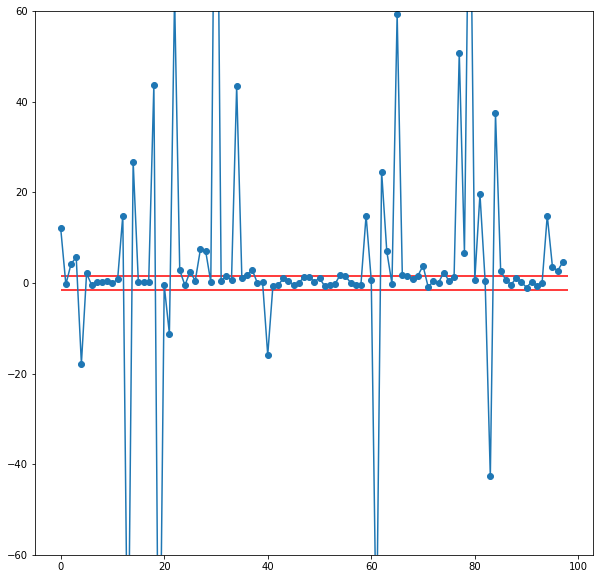

accuracy:  0.5875706214689266


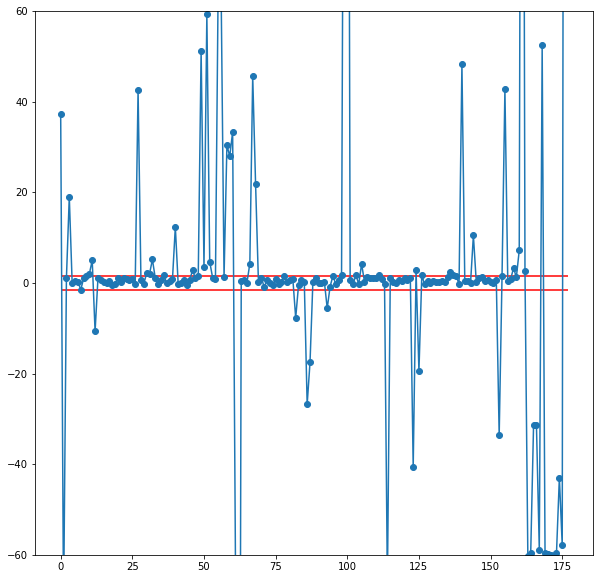

In [74]:
for key in tqdm(["128106", "127901"]):
    utterance_start = zhuyin_matching(key, weight_add=0, weight_mul=1.0, id_skip=True)
    
    ans = ansdata[key]
    print("accuracy: ", compute_metric(utterance_start, ans, tol=1.5))
    
    error=[]
    for i in range(len(ans)):
        ans_dt = datetime.strptime(ans[i], "%H:%M:%S")
        aligned_dt = datetime(1900,1,1)+timedelta(seconds=utterance_start[i])    
        #print(dt(ans_dt), dt(aligned_dt), (ans_dt-aligned_dt).total_seconds())
        error.append((ans_dt-aligned_dt).total_seconds())
    plt.figure(figsize=(10,10))
    plt.ylim(-60,60)
    plt.plot(error, marker="o")
    plt.hlines(1.5, 0, len(error), color="red")
    plt.hlines(-1.5, 0, len(error), color="red")
    plt.show()

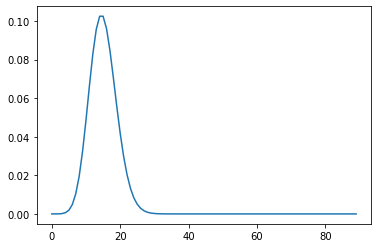

In [72]:
plt.plot(poisson.pmf(np.arange(0,90), 15))